In [1]:
import os
import glob
import cv2
import geopandas as gpd
import h5py # just a safety check so the checkpoint callback doesnt crash
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from scipy.misc import imresize
import shapely.geometry
import tensorflow as tf
print(tf.__version__)
import pandas as pd
from geopandas import GeoDataFrame
import math
import warnings
from math import floor
warnings.filterwarnings('ignore')

%matplotlib inline

1.1.0


In [38]:
from keras import backend as K
K.clear_session()


In [3]:
# Load the image summary
image_summary = gpd.read_file('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/vegas_image_summary.geojson')

# Load the nature data from OSM
osm_landuse = gpd.read_file('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/landuse_n.geojson')

# Convert everything to polygons
osm_landuse.set_geometry(osm_landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)

# Limit to just residential
residential = osm_landuse[osm_landuse.landuse == 'residential'].unary_union
forest = osm_landuse[osm_landuse.landuse == 'forest'].unary_union

# Now do the same for water
osm_nature = gpd.read_file('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/nature_n.geojson')
osm_nature.set_geometry(osm_nature.geometry.apply(shapely.geometry.Polygon), inplace=True)
water = osm_nature[osm_nature.natural == 'water'].unary_union

# Now do the same for buildings
building_footprints_i = gpd.read_file('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/building_fooprints_f.geojson')
print(len(building_footprints_i))
building_footprints_i["buffered_geometry"] = building_footprints_i["geometry"].buffer(0)
building_footprints_i = building_footprints_i.drop("geometry", axis = 1)
building_footprints_i = building_footprints_i.rename(columns = {'buffered_geometry':'geometry'})
# nulls = building_footprints_i[building_footprints_i.geometry == []]
# nulls
building_footprints= building_footprints_i.copy()
#building_footprints.set_geometry(building_footprints.geometry.apply(shapely.geometry.Polygon), inplace=True)
buildings = building_footprints.unary_union

#try to save buffered geometry as as a geojson file

vectors = [buildings]

109807


Check that the footprints line up with the houses:

In [4]:
building_footprints_check = building_footprints[building_footprints['ImageId']=='AOI_2_Vegas_img1209']

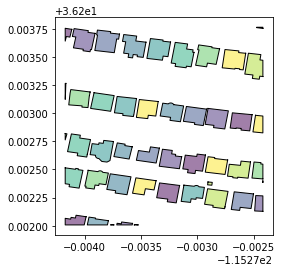

In [5]:
building_footprints_check.plot()

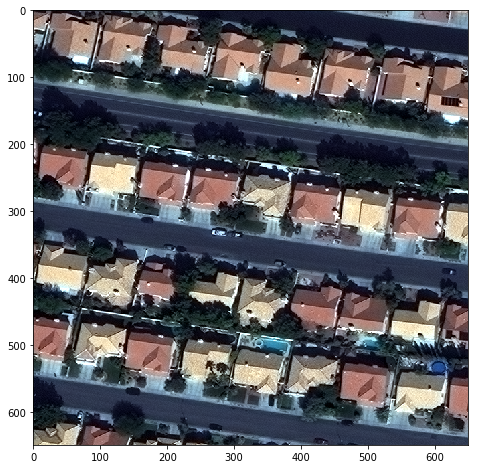

In [6]:
src = rasterio.open('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_2_Vegas_img1209.tif')
img = src.read([5, 3, 2]).transpose([1,2,0])
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled


# Plot the rescaled image
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(scale_bands(img))

In [7]:
with rasterio.open('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_2_Vegas_img1209.tif') as src:
        img = scale_bands(src.read([5, 3, 2]).transpose([1,2,0]))
        img_bounds = shapely.geometry.box(*src.bounds)
        img_transform = list(np.array(~src.transform)[[0, 1, 3, 4, 2, 5]])
        #img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
        img_crs = src.crs

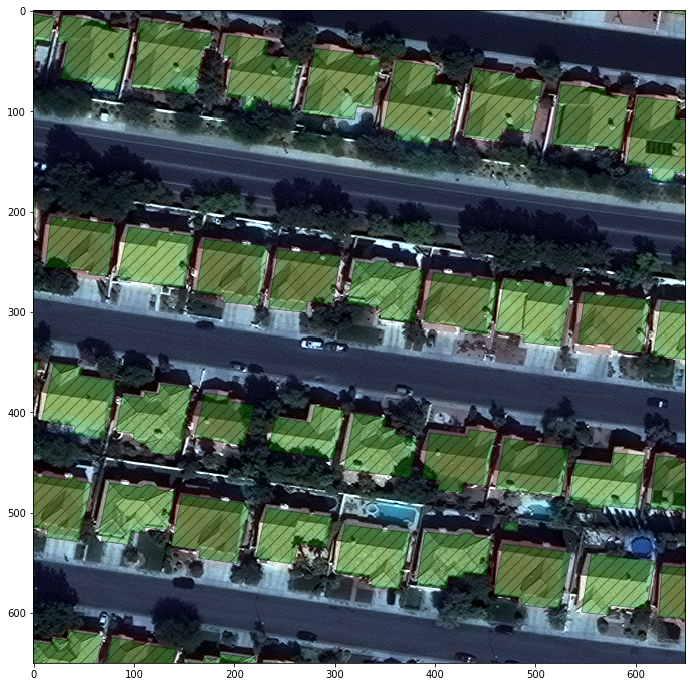

In [8]:
from descartes import PolygonPatch

# Get the intersection between the forest and the image bounds
image_building_area = vectors[0].intersection(img_bounds)

# Transform it into pixel coordinates
image_building_area_pxcoords = shapely.affinity.affine_transform(image_building_area, img_transform)

fig, ax = plt.subplots(figsize=(12,12))

# Plot the image
ax.imshow(scale_bands(img))

# Plot the forest on top of the image
ax.add_patch(PolygonPatch(image_building_area_pxcoords, fc='g', alpha=0.4, hatch='//'))

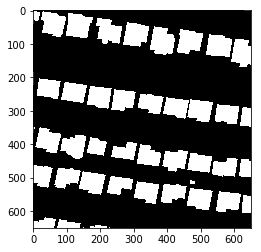

In [9]:
import cv2

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

# Convert the forest polygon into a mask
building_mask = make_mask(img.shape, image_building_area_pxcoords)

# Plot it
plt.imshow(building_mask, cmap=plt.cm.gray)

Looks good! Can make accurate training masks with these.

Make the entire training set of images. The dataframe has each building in its own row with the corresponding image that it is found in. Find the unique image ids, find the files and get their coordinates. 

image_summary_contained_images is the geometry of each image that I have building footprints for:

In [10]:
imageids = building_footprints['ImageId'].tolist()
unique_images = np.unique(imageids)
image_path = '/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/MUL-PanSharpen_'
image_path_list = []
contained_images_summary = pd.DataFrame({'images' : [], 'geometry':[]})
for pic in unique_images:
    path = image_path+pic+'.tif'
    image_path_list.append(path)

#print(image_path_list)
res = []

for image_file_name in image_path_list:
    with rasterio.open(image_file_name) as src:
        
        # Convert the image bounding box into a shapely polygon
        bbox = shapely.geometry.box(*src.bounds)
        
    res.append((image_file_name, bbox))

# Convert the results into a GeoDataFrame
image_summary_contained_images = gpd.GeoDataFrame(res, columns=['image_name', 'geometry'], crs={'init': 'epsg:4326'})
#image_summary_contained_images['image_name']


In [11]:
#image_summary_contained_images.plot()

Functions to make the trest/train split from the list of images in image_summary_contained_images

In [15]:
#INPUT_SIZE = 240 

# Recycle a couple of functions from previous notebooks...
def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    
    #ax.imshow(scale_bands(img))
    return img_scaled

def resize(img, new_shape):
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized

import pyproj
def reproject_shapely(proj_init, proj_targ, poly):
    project = functools.partial(
        pyproj.transform,
        pyproj.Proj(proj_init),
        pyproj.Proj(proj_targ)
    )
    return shapely.ops.transform(project, poly)

# Build a training set
def make_set(image_summary, vectors, training_set_percent, input_size, random=np.random):
    total_size = len(image_summary)
    train_num = int(floor(training_set_percent*total_size))
    
    rows_to_use_train = random.choice(image_summary.index, train_num, replace=False)
    #print(rows_to_use_train)
    rows_to_use_test = [x for x in image_summary.index if x not in rows_to_use_train]
    #print(rows_to_use_test)
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    n = 0
    for i, row in image_summary.loc[rows_to_use_train].iterrows():
        #print(row.image_name)
        with rasterio.open(row.image_name) as src:
                img = src.read().transpose([1,2,0])
                original_shape = img.shape[:2]
                #img = resize(img, (input_size, input_size)) #Chris found that this messes up the ground truth
                # img = scale_bands(img, lower_pct = 5, upper_pct = 95)
                img_bounds = shapely.geometry.box(*src.bounds)
                img_transform = list(np.array(~src.transform)[[0, 1, 3, 4, 2, 5]])
                #img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
                img_crs = src.crs

        masks = []
        for poly in vectors:
            # If the image is not projected in epsg:4326, we will need to change the polygon to match the image
            if not img_crs == {'init': 'epsg:4326'}:
                poly = reproject_shapely({'init': 'epsg:4326'}, img_crs, poly)
            
            # Get the intersection between the polygon and the image bounds
            mask_poly = poly.intersection(img_bounds)

            # Transform it into pixel coordinates
            mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)

            # Convert the polygon into a mask
            mask = make_mask(original_shape, mask_poly_pxcoords)
            mask = imresize(mask, (input_size, input_size))
            
            masks.append(mask[..., None])
        masks = np.concatenate(masks, axis=2)
        
        img = resize(img, (input_size, input_size)) 
        
        # Add each mask to a list
        X_train.append(img[None, ...]) # These need to be truncated for U-Net
        Y_train.append(masks[None, ...])
        n=n+1
        if n%50 == 0:
            print("Making mask for train image:", n)
        else:
            continue
            
    # Concatenate the results
    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.concatenate(Y_train, axis=0)
    
    # Normalize the values
    X_train = X_train.astype('float32')
    X_train = (X_train / X_train.max() - 0.5) * 2 # put X in range [-1, 1]
    Y_train = Y_train.astype('float32') / 255 # put Y in range [0, 1]
    
    n=0
    for i, row in image_summary.loc[rows_to_use_test].iterrows():
        #print(row.image_name)
        with rasterio.open(row.image_name) as src:
                img = src.read().transpose([1,2,0])
                original_shape = img.shape[:2]
                #img = resize(img, (input_size, input_size)) #Chris found that this messes up the ground truth
                # img = scale_bands(img, lower_pct = 5, upper_pct = 95)
                img_bounds = shapely.geometry.box(*src.bounds)
                img_transform = list(np.array(~src.transform)[[0, 1, 3, 4, 2, 5]])
                #img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
                img_crs = src.crs

        masks = []
        for poly in vectors:
            # If the image is not projected in epsg:4326, we will need to change the polygon to match the image
            if not img_crs == {'init': 'epsg:4326'}:
                poly = reproject_shapely({'init': 'epsg:4326'}, img_crs, poly)
            
            # Get the intersection between the polygon and the image bounds
            mask_poly = poly.intersection(img_bounds)

            # Transform it into pixel coordinates
            mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)

            # Convert the polygon into a mask
            mask = make_mask(original_shape, mask_poly_pxcoords)
            mask = imresize(mask, (input_size, input_size))
            
            masks.append(mask[..., None])
        masks = np.concatenate(masks, axis=2)
        
        img = resize(img, (input_size, input_size)) 
        
        # Add each mask to a list
        X_test.append(img[None, ...]) # These need to be truncated for U-Net
        Y_test.append(masks[None, ...])
        
        n=n+1
        if n%50 == 0:
            print("Making mask for test image:", n)
        else:
            continue
            
    # Concatenate the results
    X_test = np.concatenate(X_test, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)
    
    # Normalize the values
    X_test = X_test.astype('float32')
    X_test = (X_test / X_test.max() - 0.5) * 2 # put X in range [-1, 1]
    Y_test = Y_test.astype('float32') / 255 # put Y in range [0, 1]
    
    print("Train set length:", len(rows_to_use_train), "Test set length:", len(rows_to_use_test))
    return X_train, Y_train, X_test, Y_test, rows_to_use_train, rows_to_use_test

def make_pascal_set(data_list_path, data_path, training_set_size, input_size, random=np.random):
    pass


(optionally can downsample the dataset to a more manageable. Currently is ~4000 images which is a little big. This will make a randomly selected subset from the list in image_summary_contained_images)

In [1]:
test_df = image_summary_contained_images.sample(500, axis = 0, random_state = 2).reset_index()
print("Your new dataset contains", len(test_df)," images for training and testing")

NameError: name 'image_summary_contained_images' is not defined

Now make train/test set!

In [14]:
INPUT_SIZE = 480
random = np.random.RandomState(2) 
X_train, Y_train, X_val, Y_val, train_length, test_length = make_set(test_df, vectors, 0.7, INPUT_SIZE, random=np.random)


('Making mask for train image:', 50)
('Making mask for train image:', 100)
('Making mask for train image:', 150)
('Making mask for train image:', 200)
('Making mask for train image:', 250)
('Making mask for train image:', 300)
('Making mask for train image:', 350)
('Making mask for test image:', 50)
('Making mask for test image:', 100)
('Making mask for test image:', 150)
('Train set length:', 350, 'Test set length:', 150)


In [16]:
def plot_example(X, Y):
    # Apply the model to this example
   
    
    fig, axes = plt.subplots(1,2, figsize=(15,15))
    
    # Iterate through each target class
    for tno in range(1):
        
        #targ = Y[tno]
        #pred = prediction[tno]
        
        targ = Y[:, :, tno]
        #pred = prediction[:, :, tno]

        ax1, ax2 = axes

        ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement

        #ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement
        ax2.imshow(targ, vmin=0, vmax=1)
        #ax3.imshow(pred, vmin=0, vmax=1)

        ax1.set_title('Image')
        ax2.set_title('Ground Truth')
        #ax3.set_title('Prediction')
    plt.show()


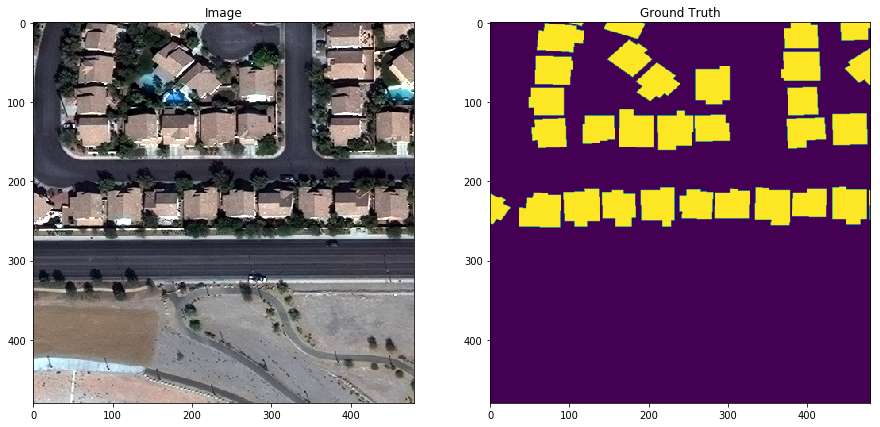

In [17]:
plot_example(X_train[30], Y_train[30])

In [18]:
X_train.shape

(350, 480, 480, 8)

In [19]:
#Save train and test sets to use later
#X_train, Y_train, X_val, Y_val
np.save('Train_set_Buildings_480_X.npy',X_train)
np.save('Train_set_Buildings_480_Y.npy', Y_train)
np.save('Test_set_Buildings_480_X.npy', X_val)
np.save('Test_set_Buildings_480_Y.npy', Y_val)

In [20]:
#check = np.load('Train_set_Buildings_tt_X.npy')

In [21]:
#check == X_train

In [22]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

import keras
from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam

# Set network size params
N_CLASSES = 1
N_CHANNEL = 8

# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Just put a negative sign in front of an accuracy metric to turn it into a loss to be minimized
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def get_unet(lr=0.001):
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=Adam(lr=lr), loss=jacc_coef_loss, metrics=[jacc_coef_int])
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[dice_coef])

    return model

In [24]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
# https://keras.io/callbacks/#reducelronplateau

# This sets the number of training epochs (you should do a lot more than 5)
NUM_EPOCHS = 75

# Define callback to save model checkpoints
if not os.path.exists('checkpoints_480_check'):
    os.makedirs('checkpoints_480_check')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints_480_check', 'weights.{epoch:02d}-{val_loss:.5f}.hdf5'), monitor='loss', save_best_only=True)

# Define callback to reduce learning rate when learning stagnates
# This won't actually kick in with only 5 training epochs, but I'm assuming you'll train for hundreds of epochs when you get serious about training this NN.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, epsilon=0.002, cooldown=2)

# # Define rate scheduler callack (this is an alternative to ReduceLROnPlateau. There is no reason to use both.)
# schedule = lambda epoch_i: 0.01*np.power(0.97, i)
# schedule_lr = LearningRateScheduler(schedule)

# TensorBoard visuluaziations... this stuff is so freaking cool
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs2_480_check', histogram_freq=0, write_graph=True, write_images=True)

# Train the model
model = get_unet(0.001)
model.fit(X_train, Y_train, batch_size=20, epochs=NUM_EPOCHS, verbose=1, shuffle=True, callbacks=[model_checkpoint, reduce_lr, tensorboard], validation_data=(X_val, Y_val))

Train on 350 samples, validate on 150 samples
Epoch 1/75
350/350 [==============================] - 101s - loss: 0.4927 - jacc_coef_int: 0.0790 - val_loss: 0.3768 - val_jacc_coef_int: 0.2788
Epoch 2/75
350/350 [==============================] - 98s - loss: 0.3751 - jacc_coef_int: 0.3299 - val_loss: 0.3442 - val_jacc_coef_int: 0.3641
Epoch 3/75
350/350 [==============================] - 98s - loss: 0.3505 - jacc_coef_int: 0.4015 - val_loss: 0.3215 - val_jacc_coef_int: 0.4244
Epoch 4/75
350/350 [==============================] - 99s - loss: 0.3288 - jacc_coef_int: 0.4325 - val_loss: 0.3160 - val_jacc_coef_int: 0.4620
Epoch 5/75
350/350 [==============================] - 98s - loss: 0.3252 - jacc_coef_int: 0.4235 - val_loss: 0.3112 - val_jacc_coef_int: 0.4876
Epoch 6/75
350/350 [==============================] - 98s - loss: 0.3030 - jacc_coef_int: 0.4642 - val_loss: 0.2739 - val_jacc_coef_int: 0.5076
Epoch 7/75
350/350 [==============================] - 98s - loss: 0.2887 - jacc_coef_int:

Save model to disk

In [25]:
model_480_json = model.to_json()
with open("model_480_check.json", "w") as json_file:
    json_file.write(model_480_json)
# serialize weights to HDF5
model.save_weights("model_480_check.h5")
print("Saved model_480_check to disk")

Saved model_480_check to disk


In [26]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 480, 480, 8)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 480, 480, 32)      2336      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 480, 480, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 240, 240, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 240, 240, 64)      18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 240, 240, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 120, 64)      0         
__________

Show some examples on the test set:


In [27]:
# Function to create an iterator with examples
def get_examples():
    for i in range(Y_val.shape[0]):
        #print(i)
        if Y_val[i, ...].sum() > 0.5:
            X = X_val[i]
            #print(X)
            Y = Y_val[i]
            print(Y_val[i].shape)
            print(X_val[i].shape)
            yield X, Y

# Function to plot a single example
def plot_example(X, Y, model):
    # Apply the model to this example
    prediction = model.predict(X[None, ...])[0, ...] > 0.15
    #print(prediction)
    
    fig, axes = plt.subplots(1,3, figsize=(15,15))
    tno = 0
    # Iterate through each target class
    #for tno in range(1):
        
    targ = Y[:, :, tno]
    pred = prediction[:, :, tno]

    ax1, ax2, ax3 = axes
    ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement

    #ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement
    ax2.imshow(targ, vmin=0, vmax=1)
    ax3.imshow(pred, vmin=0, vmax=1)

    ax1.set_title('Image')
    ax2.set_title('Ground Truth')
    ax3.set_title('Prediction')
    plt.show()


# # If you need to load the model, you can use these lines.  Change the weights filename to match one you have.
#model = get_unet()
#model.load_weights('checkpoints/weights.99-0.07128.hdf5')


example_generator = get_examples()

(480, 480, 1)
(480, 480, 8)


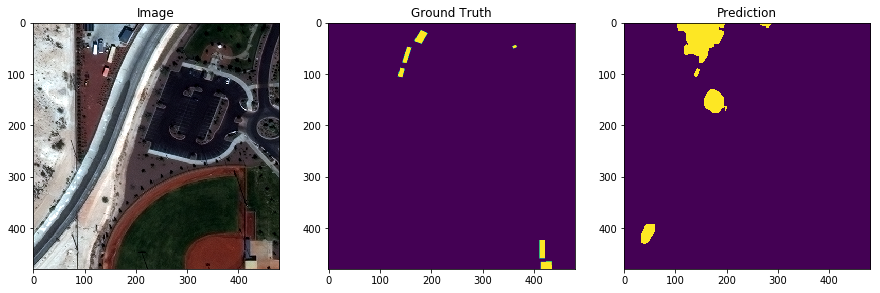

In [28]:
X, Y = next(example_generator)
plot_example(X, Y, model)

(480, 480, 1)
(480, 480, 8)


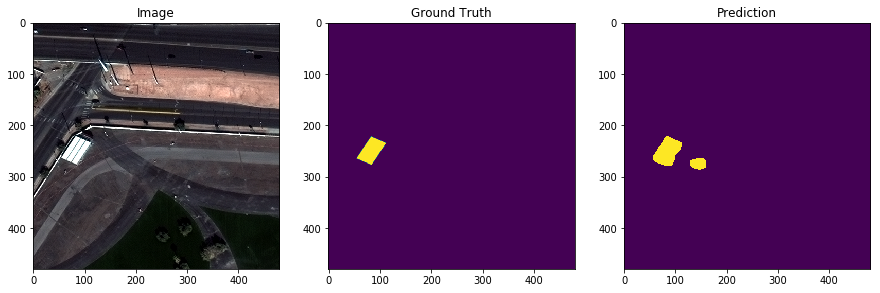

In [29]:
X, Y = next(example_generator)
plot_example(X, Y, model)

(480, 480, 1)
(480, 480, 8)


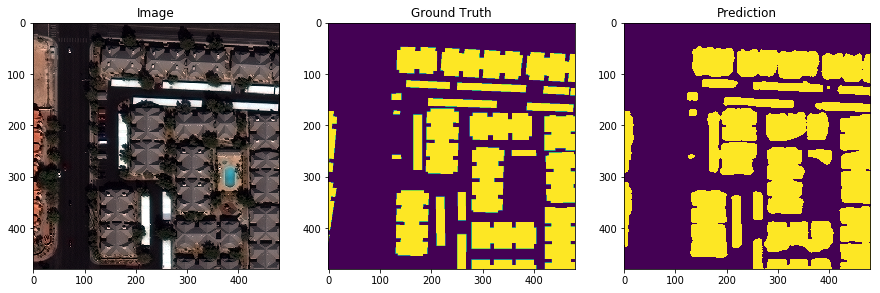

In [30]:
X, Y = next(example_generator)
plot_example(X, Y, model)

(480, 480, 1)
(480, 480, 8)


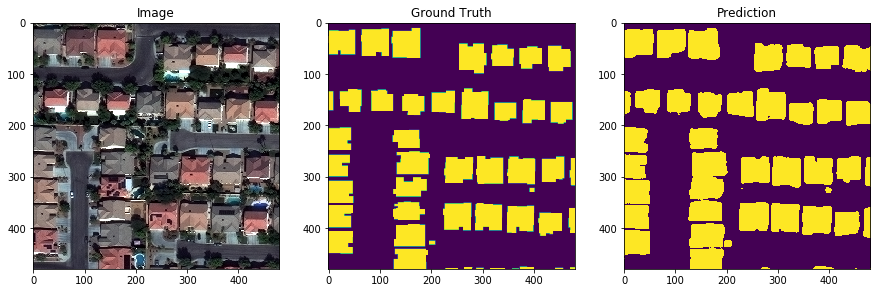

In [31]:
X, Y = next(example_generator)
plot_example(X, Y, model)

(480, 480, 1)
(480, 480, 8)


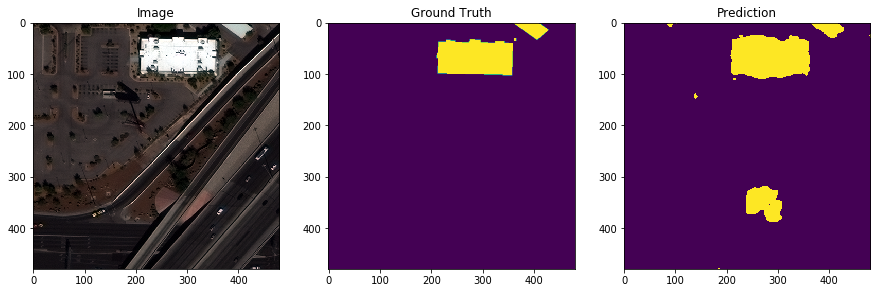

In [32]:
X, Y = next(example_generator)
plot_example(X, Y, model)

(480, 480, 1)
(480, 480, 8)


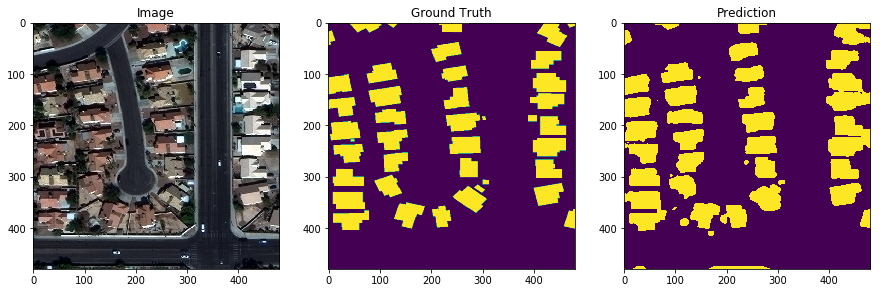

In [33]:
X, Y = next(example_generator)
plot_example(X, Y, model)

Try to sumperimpose prediction on the image:

In [35]:
from descartes import PolygonPatch

def plot_example(X, Y, model):
    # Apply the model to this example
    prediction = model.predict(X[None, ...])[0, ...] > 0.2
    #print(prediction)
    #print(prediction)
    fig, ax = plt.subplots(figsize=(10,10))
    #fig, axes = plt.subplots(1,3, figsize=(15,15))
    tno = 0
    # Iterate through each target class
    #for tno in range(1):
        
    targ = Y[:, :, 0]
    pred = prediction[:, :, 0]
    print(pred.shape)
    #ax1, ax2, ax3 = axes
    ax.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement

    #ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement
    #ax2.imshow(targ, vmin=0, vmax=1)
    #ax3.imshow(pred, vmin=0, vmax=1)
    ax.imshow(pred, cmap=plt.cm.jet, alpha=0.4,vmin=0.1, vmax=1) #, fc='g', alpha=0.4, hatch='//')
    #ax.add_patch(PolygonPatch(pred, fc='g', alpha=0.4, hatch='//'))
    
    
    #ax1.set_title('Image')
    #ax2.set_title('Ground Truth')
    #ax3.set_title('Prediction')
    plt.show()

(480, 480)


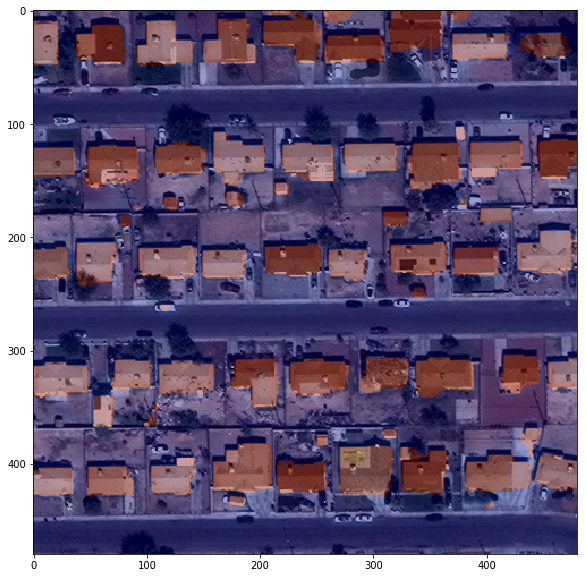

In [36]:
plot_example(X_val[10], Y_val[10], model)

(480, 480)


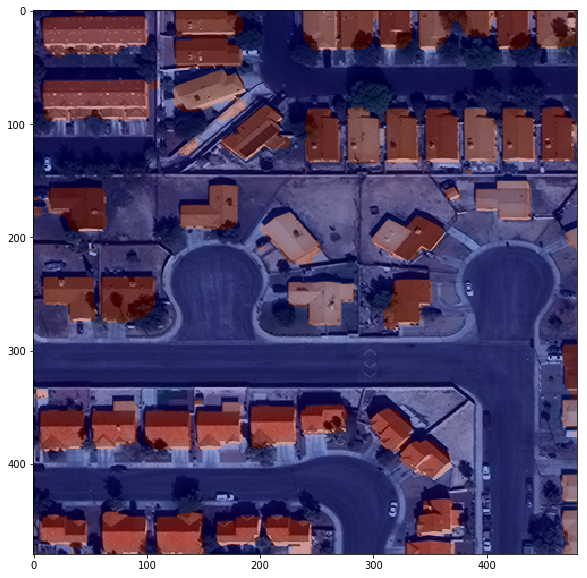

In [37]:
plot_example(X_val[20], Y_val[20], model)